**Table of Contents**
<div id="toc"></div>

# Log


# Imports

In [1]:
import os.path
from math import isnan

import pandas
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import container
# from matplotlib.lines import Line2D

from person import Person
from visit import Visit

# from model import create_vae


from keras import backend as K
from keras.layers import LSTM, Input, RepeatVector
from keras.models import Sequential, Model
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.optimizers import SGD, RMSprop, Adam
from keras import objectives

Using TensorFlow backend.


# Constants

In [2]:
# Number of visits to be used in the model
NR_VISITS = 4

# currently read vars from each enroll visit
fields_enroll = ['subjid', 'seq', 'visit', 'age', 'hdcat', 'motscore', 'miscore', 'tfcscore', 'fascore', 'fiscore',
                 'sdmt1', 'sdmt2', 'sit1', 'sit2', 'sit3', 'depscore', 'irascore', 'psyscore', 'aptscore', 'exfscore']

# currently read vars from each profile
fields_profile = ['subjid', 'sex', 'region', 'race', 'hxsid', 'caghigh', 'caglow', 'momhd', 'momagesx', 'dadhd',
                  'dadagesx', 'fhx']

# current vars used in the model
_vars = ['caglow', 'caghigh', 'tfcscore', 'motscore', 'age']
# 'fascore', 'depscore', 'sdmt1'] 

# Profile plot generation (def)

In [3]:
def generate_profile_plots():
    print("not done")
    
    

    # Some plots #

    # Sex distribution by group:
    sex_count = np.zeros(shape=(2, 3))

    for i in persons:
        if i.state == 3:
            j = 2
        elif i.state == 2:
            j = 1
        else:
            j = 0
        if i.sex == 0:
            sex_count[0, j] += 1
        elif i.sex == 1:
            sex_count[1, j] += 1
        else:
            print("Sex NA")

    # fig, ax = plt.subplots()
    # ind = np.arange(3)
    # width = 0.35
    # rects1 = ax.bar(ind, sex_count[0])
    # rects2 = ax.bar(ind+ width, sex_count[1], color='black')
    # ax.set_ylabel('#')
    # ax.set_title('Gender by group')
    # ax.set_xticks(ind + width / 2)
    # xTickMarks = ['Control', 'Pre-Manifest', 'Post-Manifest']
    # xtickNames = ax.set_xticklabels(xTickMarks)
    # plt.setp(xtickNames, rotation=45, fontsize=10)
    # ax.legend( (rects1[0], rects2[0]), ('Women', 'Men') )


    # ax.set_xticklabels(('Control', 'Pre-Manifest', 'Post-Manifest'))
    # ax.legend((rects1[0], rects2[0]), ('Women', 'Men'))
    # ax.set_ylabel('#')
    # ax.set_title('Sex distribuition over classification group')

# _vars plot generation (def)

generate_vars_plots(): Generates some plots for the variables used in the model. The plots are the mean and std and a scatter plot showing where the data is distributed along each visit. Blue for Controls, Yellow for Pre-Manifest and Red for Post-Manifest.

In [4]:
def generate_vars_plots():

    def autolabel():
        # Attach a text label next to each value to display its value (only used for mean atm)
        
        for i in ind:
            axs1[0].text(i + 0.24*width, mean[i, _index] + axs1[0].get_yaxis().get_tick_padding()*0.2, '%f' % mean[i, _index], fontsize=15)
            axs1[0].text(i + 1.04*width, mean_pre[i, _index] + axs1[0].get_yaxis().get_tick_padding()*0.2, '%f' % mean_pre[i, _index], fontsize=15)
            axs1[0].text(i + 1.84*width, mean_post[i, _index] + axs1[0].get_yaxis().get_tick_padding()*0.2, '%f' % mean_post[i, _index], fontsize=15)

    for var in _vars:
        _index = _vars.index(var)
        ind = np.arange(NR_VISITS)
        width = 0.30
        fig1, axs1 = plt.subplots(2, 1, figsize=(20, 10), sharex='col')
        fig1.suptitle(var, fontsize=16)
        
        rects_1 = axs1[0].errorbar(ind + 0.2*width, mean[:, _index], std[:, _index], color='b', linestyle='None', marker='o', capsize=2, label="Control")
        rects_2 = axs1[0].errorbar(ind + width, mean_pre[:, _index], std_pre[:, _index], color='y', linestyle='None', marker='o', capsize=2, label="Pre")
        rects_3 = axs1[0].errorbar(ind + (1.8*width), mean_post[:, _index], std_post[:, _index], color='r',
                                   linestyle='None', marker='o', capsize=2, label="Post")
        
        axs1[0].set_ylabel('Value')
        axs1[0].set_title("Mean and std")
        axs1[0].set_xticks(ind + width)
        start, end = axs1[0].get_ylim()
        axs1[0].set_yticks(np.arange(round(start)-1, round(end)+1, round((end-start)/10)))
        axs1[0].grid(linestyle='--', alpha=0.7)
        autolabel()

        # Remove std drawing from the legend
        handles, labels = axs1[0].get_legend_handles_labels()
        new_handles = []

        for h in handles:
            # only need to edit the errorbar legend entries
            if isinstance(h, container.ErrorbarContainer):
                new_handles.append(h[0])
            else:
                new_handles.append(h)

        fig1.legend(new_handles, labels, loc='center right')
        fig1.subplots_adjust(hspace=0.15)

        # Scatter Plot #
        
        axs1[1].set_ylabel('Value')
        axs1[1].set_xlabel('Visit Number')
        axs1[1].set_title("Scatter plot")
        axs1[1].set_xticks(ind + width)
        axs1[1].set_xticklabels(np.arange(1,NR_VISITS+1))

        # create x values for all the Y values with random to distribute them along the visit's width
        for z in ind:
            _x1 = np.ones(control_data.shape[0])*(z + 0.2*width) + (np.random.uniform(-1.0, 1.0, control_data.shape[0]) * width/3)
            axs1[1].scatter(_x1, control_data[:, z, _index], facecolors='none', edgecolor='b', s=5)
            
            _x2 = np.ones(pre_data.shape[0])*(z + width) + (np.random.uniform(-1.0, 1.0, pre_data.shape[0]) * width/3)
            axs1[1].scatter(_x2, pre_data[:, z, _index], facecolors='none', edgecolor='y', s=5)
            
            _x3 = np.ones(post_data.shape[0])*(z + 1.8*width) + (np.random.uniform(-1.0, 1.0, post_data.shape[0]) * width/3)
            axs1[1].scatter(_x3, post_data[:, z, _index], facecolors='none', edgecolor='r', s=5)
            
        start, end = axs1[1].get_ylim()
        axs1[1].set_yticks(np.arange(round(start)-1, round(end)+1, round((end-start)/10)))
        axs1[1].grid(linestyle='--', alpha=0.7)

    plt.show()

# Prediction plot generation (def)

In [5]:
    # Plots after prediction
    
    def generate_pred_plots():
        
        n_plots = NR_VISITS
        #print(n_plots)
        n_cols = n_plots // 2
        #print(n_cols)
        n_rows = n_plots // n_cols
        #print(n_rows)
        n_rows += n_plots % n_cols
        #print(n_rows)
        position = np.arange(1, n_plots +1)
        
        for var in _vars:
            _index = _vars.index(var)
            fig = plt.figure(1, figsize=(20,10))
            fig.suptitle(var, fontsize=16)
            for i in range(NR_VISITS):
                ax = fig.add_subplot(n_rows, n_cols, position[i])
                ax.plot(control_data[:, i, _index], 'ro', mfc='none', label='data')
                ax.plot(preds[:, i, _index], 'bo', mfc='none', label='predict')
                ax.legend(loc='upper right')
                ax.set_title("Visit %d" % (i+1))
            
            plt.show()
                

# Get Data

Get the data from the DB

In [6]:
    pre = 0
    post = 0
    control = 0

    nr_vis_ok = {}
    nr_vis = {}

    list_visits = []
    list_pre = []
    list_post = []
    list_control = []

    if os.path.exists('Data/enroll.csv'):
        df = pandas.read_csv('Data/enroll.csv', dtype={"age": str}, usecols=fields_enroll)
        #print(df)
    else:
        print("no file - enroll.csv")

    if os.path.exists('Data/profile.csv'):
        df_p = pandas.read_csv('Data/profile.csv', delimiter='\t', usecols=fields_profile)
        #print(df_p)
    else:
        print("no file - profile.csv")
        
    subjids = {}
    persons = []
    count = 0
    df2 = df.values
    df2_p = df_p.values

    for index, i in enumerate(df['subjid']):

        seq = df2[index, 1]
        visit = df2[index, 2]
        age = df2[index, 3] if df2[index, 3] != '<18' else '17'
        hdcat = df2[index, 4]
        motscore = df2[index, 5]
        miscore = df2[index, 6]
        tfcscore = df2[index, 7]
        fascore = df2[index, 8]
        fiscore = df2[index, 9]
        sdmt1 = df2[index, 10]
        sdmt2 = df2[index, 11]
        sit1 = df2[index, 12]
        sit2 = df2[index, 13]
        sit3 = df2[index, 14]
        depscore = df2[index, 15]
        irascore = df2[index, 16]
        psyscore = df2[index, 17]
        aptscore = df2[index, 18]
        exfscore = df2[index, 19]
        

        # New ENROLL visit data (selected)

        new_visit = Visit(seq, age, visit, hdcat, motscore, miscore, tfcscore, fascore, fiscore, sdmt1, sdmt2, sit1,
                          sit2, sit3, depscore, irascore, psyscore, aptscore, exfscore)

        if i not in subjids:
            # New person

            persons.append(Person(i, hdcat))
            persons[count].add_visit(new_visit)

            # Count Baseline and FUP only
            if new_visit.visit in ['Baseline', 'Follow Up']:
                persons[count].visits_ok += 1

            # Index in persons array
            count += 1

            # Total visit count
            subjids[i] = 1

        else:
            # Increase counters and add new visit
            subjids[i] += 1
            persons[count-1].add_visit(new_visit)
            if new_visit.visit in ['Baseline', 'Follow Up']:
                persons[count-1].visits_ok += 1
    
    # counters  for each of the 3 groups
    for i in persons:
        if i.state == 2:
            pre += 1
        elif i.state == 3:
            post += 1
        else:
            control += 1

        if i.visits_ok not in nr_vis_ok:
            nr_vis_ok[i.visits_ok] = 1
        else:
            nr_vis_ok[i.visits_ok] += 1
        if i.visits not in nr_vis:
            nr_vis[i.visits] = 1
        else:
            nr_vis[i.visits] += 1

        if i.visits_ok == NR_VISITS:
            # Persons with visits total = visits baseline + FUP
            list_visits.append(i)
            # Separated by control, pre-manifest, and post-manifest
            if i.state == 2:
                list_pre.append(i)
            elif i.state == 3:
                list_post.append(i)
            else:
                list_control.append(i)
        if i.visits_ok > NR_VISITS:
            for x in range(i.visits_ok - NR_VISITS +1):
                if i.visit_list[x].visit in ['Baseline', 'Follow UP'] and i.visit_list[x+1].visit in ['Baseline', 'Follow UP'] and i.visit_list[x+2].visit in ['Baseline', 'Follow UP'] and i.visit_list[x+3].visit in ['Baseline', 'Follow UP']:
                    list_visits.append(i)
                    if i.state==2:
                        list_pre.append(i)
                    elif i.state == 3:
                        list_post.append(i)
                    else:
                        list_control.append(i)
                    # only add the first NR_VISITS good, in case there are more combinations
                    break
            

    for index, i in enumerate(df_p['subjid']):
        region = df2_p[index, 1]
        sex = df2_p[index, 2]
        race = df2_p[index, 3]
        hxsid = df2_p[index, 4]
        caghigh = df2_p[index, 5] if df2_p[index, 5] != ">70" else '71'
        caglow = df2_p[index, 6] if df2_p[index, 6] != ">28" else '29'
        momhd = df2_p[index, 7]
        momagesx = df2_p[index, 8]
        dadhd = df2_p[index, 9]
        dadagesx = df2_p[index, 10]
        fhx = df2_p[index, 11]

        persons[index].add_info(region, sex, race, hxsid, caghigh, caglow, momhd, momagesx, dadhd, dadagesx, fhx)

    # Data #
    
    #Info#
    pre_caghigh=0
    pre_caglow=0
    pre_bothcag=0
    pre_underage=0
    post_caghigh=0
    post_caglow=0
    post_bothcag=0
    post_underage=0
    control_caghigh=0
    control_caglow=0
    control_bothcag =0
    control_underage =0
    
    for p in persons:
        if p.state == 2:
            #pre
            if p.visit_list[0].age == '17':
                pre_underage +=1
            if  p.caghigh == '71' and p.caglow == '29':
                pre_bothcag +=1
            else:
                if p.caghigh == '71':
                    pre_caghigh +=1
                if p.caglow == '29':
                    pre_caglow +=1
        elif p.state == 3:
            #post
            if p.visit_list[0].age == '17':
                post_underage +=1
            if  p.caghigh == '71' and p.caglow == '29':
                pre_bothcag +=1
            else:
                if p.caghigh == '71':
                    post_caghigh +=1
                if p.caglow == '29':
                    post_caglow +=1
        else:
            #control
            if p.visit_list[0].age == '17':
                control_underage +=1
            if  p.caghigh == '71' and p.caglow == '29':
                control_bothcag +=1
            else:
                if p.caghigh == '71':
                    control_caghigh +=1
                if p.caglow == '29':
                    control_caglow +=1
    
    print("From total data: %d controls, %d Pre, %d post: \n" % (pre, post, control))
    print("Controls: caghigh - %d    caglow - %d  both - %d" % (control_caghigh, control_caglow, control_bothcag))
    print("Pre: caghigh - %d    caglow - %d both - %d" % (pre_caghigh, pre_caglow, pre_bothcag))
    print("Post: caghigh - %d    caglow - %d  both - %d" % (post_caghigh, post_caglow, post_bothcag))
    print("Underage: Control %d ; Pre %d ; Post %d \n" % (control_underage, pre_underage, post_underage))
    
    pre_caghigh=0
    pre_caglow=0
    pre_bothcag=0
    pre_underage=0
    post_caghigh=0
    post_caglow=0
    post_bothcag=0
    post_underage=0
    control_caghigh=0
    control_caglow=0
    control_bothcag =0
    control_underage =0
    
    for p in list_visits:
        if p.state == 2:
            #pre
            if p.visit_list[0].age == '17':
                pre_underage +=1
            if  p.caghigh == '71' and p.caglow == '29':
                pre_bothcag +=1
            else:
                if p.caghigh == '71':
                    pre_caghigh +=1
                if p.caglow == '29':
                    pre_caglow +=1
        elif p.state == 3:
            #post
            if p.visit_list[0].age == '17':
                post_underage +=1
            if  p.caghigh == '71' and p.caglow == '29':
                pre_bothcag +=1
            else:
                if p.caghigh == '71':
                    post_caghigh +=1
                if p.caglow == '29':
                    post_caglow +=1
        else:
            #control
            if p.visit_list[0].age == '17':
                control_underage +=1
            if  p.caghigh == '71' and p.caglow == '29':
                control_bothcag +=1
            else:
                if p.caghigh == '71':
                    control_caghigh +=1
                if p.caglow == '29':
                    control_caglow +=1
    
    
    print("From data to be used: %d controls, %d Pre, %d post: \n" % (len(list_pre), len(list_post), len(list_control)))
    print("Controls: caghigh - %d    caglow - %d  both - %d" % (control_caghigh, control_caglow, control_bothcag))
    print("Pre: caghigh - %d    caglow - %d both - %d" % (pre_caghigh, pre_caglow, pre_bothcag))
    print("Post: caghigh - %d    caglow - %d  both - %d" % (post_caghigh, post_caglow, post_bothcag))
    print("Underage: Control %d ; Pre %d ; Post %d \n" % (control_underage, pre_underage, post_underage))

    # For the model #
    
    control_data = np.zeros(shape=(len(list_control), NR_VISITS, len(_vars)))
    pre_data = np.zeros(shape=(len(list_pre), NR_VISITS, len(_vars)))
    post_data = np.zeros(shape=(len(list_post), NR_VISITS, len(_vars)))

    control_labels = np.chararray(shape=(len(list_control), 1))
    pre_labels = np.chararray(shape=(len(list_pre), 1))
    post_labels = np.chararray(shape=(len(list_post), 1))

    for index, i in enumerate(list_control):
        c = 0
        for index2, j in enumerate(i.visit_list):
            if j.visit != "Phone Contact":
                control_data[index, c, 0] = i.caglow
                control_data[index, c, 1] = i.caghigh
                control_data[index, c, 2] = j.tfcscore
                control_data[index, c, 3] = j.motscore if j.motscore == j.motscore else j.miscore
                control_data[index, c, 4] = j.age 
                #control_data[index, c, 5] = j.fascore if j.fascore == j.fascore else j.fiscore
                #control_data[index, c, 6] = j.depscore
                #control_data[index, c, 7] = j.sdmt1
                
                c += 1
                if c == NR_VISITS:
                    break
        control_labels[index] = i.subjid

    for index, i in enumerate(list_pre):
        c = 0
        for index2, j in enumerate(i.visit_list):
            if j.visit != "Phone Contact":
                pre_data[index, c, 0] = i.caglow
                pre_data[index, c, 1] = i.caghigh 
                pre_data[index, c, 2] = j.tfcscore
                pre_data[index, c, 3] = j.motscore if j.motscore == j.motscore else j.miscore
                pre_data[index, c, 4] = j.age
                #pre_data[index, c, 5] = j.fascore if j.fascore == j.fascore else j.fiscore
                #pre_data[index, c, 6] = j.depscore
                #pre_data[index, c, 7] = j.sdmt1
                c += 1
                if c == NR_VISITS:
                    break
        pre_labels[index] = i.subjid

    for index, i in enumerate(list_post):
        c = 0
        for index2, j in enumerate(i.visit_list):
            if j.visit != "Phone Contact":
                post_data[index, c, 0] = i.caglow 
                post_data[index, c, 1] = i.caghigh
                post_data[index, c, 2] = j.tfcscore
                post_data[index, c, 3] = j.motscore if j.motscore == j.motscore else j.miscore
                post_data[index, c, 4] = j.age
               # post_data[index, c, 5] = j.fascore if j.fascore == j.fascore else j.fiscore
                #post_data[index, c, 6] = j.depscore
                #post_data[index, c, 7] = j.sdmt1
                c += 1
                if c == NR_VISITS:
                    break
        post_labels[index] = i.subjid

    control_data = control_data.astype('float32')
    pre_data = pre_data.astype('float32')
    post_data = post_data.astype('float32')

    # Entries to be removed from the used data - ones with nan values on the required fields or missing/wrong 999* and outliers -> age =17,
    # caghigh = 71, caglow = 29 
    
    print("Removing the unwanted data from controls \n")
    to_del = []
    
    for index, x1 in np.ndenumerate(control_data):
        if isnan(x1) or x1 in [9999,9998,9997,9996] or (x1 == 71 and index[2] == 1) or (x1 == 29 and index[2] == 0) or (x1 == 17 and index[2]==4):
            #print(index, x1, end='\n')
            if index[0] not in to_del:
                to_del.append(index[0])
                
    print("Removing %d entries from control data" % len(to_del))
    print("Old control -> %s" % (control_data.shape,))
    control_data = np.delete(control_data, to_del, 0)
    control_labels = np.delete(control_labels, to_del, 0)
    print("New control -> %s\n" % (control_data.shape,))
    
    print("Removing the unwanted data from pre \n")
    to_del = []
    for index, x1 in np.ndenumerate(pre_data):
        if isnan(x1) or x1 in [9999,9998,9997,9996] or (x1 == 71 and index[2] == 1) or (x1 == 29 and index[2] == 0) or (x1 == 17 and index[2]==4):
            #print(index, x1, end='\n')
            if index[0] not in to_del:
                to_del.append(index[0])
    
    print("Removing %d entries from pre data" % len(to_del))
    print("Old pre -> %s" % (pre_data.shape,))
    pre_data = np.delete(pre_data, to_del, 0)
    pre_labels = np.delete(pre_labels, to_del, 0)
    print("New pre -> %s\n" % (pre_data.shape,))
    
    print("Removing the unwanted data from post \n")
    
    to_del = []
    for index, x1 in np.ndenumerate(post_data):
        if isnan(x1) or x1 in [9999,9998,9997,9996] or (x1 == 71 and index[2] == 1) or (x1 == 29 and index[2] == 0) or (x1 == 17 and index[2]==4):
            #print(index, x1, end='\n')
            if index[0] not in to_del:
                to_del.append(index[0])
                
    print("Removing %d entries from post data" % len(to_del))
    print("Old post -> %s" % (post_data.shape,))
    post_data = np.delete(post_data, to_del, 0)
    post_labels = np.delete(post_labels, to_del, 0)
    print("New post -> %s\n" % (post_data.shape,))
    
    # mean and std #

    std = control_data.std(axis=0)
    mean = control_data.mean(axis=0)

    std_pre = pre_data.std(axis=0)
    mean_pre = pre_data.mean(axis=0)

    std_post = post_data.std(axis=0)
    mean_post = post_data.mean(axis=0)


From total data: 2842 controls, 7324 Pre, 5135 post: 

Controls: caghigh - 2    caglow - 27  both - 0
Pre: caghigh - 0    caglow - 38 both - 0
Post: caghigh - 26    caglow - 143  both - 0
Underage: Control 5 ; Pre 2 ; Post 24 

From data to be used: 395 controls, 1343 Pre, 439 post: 

Controls: caghigh - 0    caglow - 2  both - 0
Pre: caghigh - 0    caglow - 4 both - 0
Post: caghigh - 2    caglow - 27  both - 0
Underage: Control 0 ; Pre 0 ; Post 2 

Removing the unwanted data from controls 

Removing 4 entries from control data
Old control -> (439, 4, 5)
New control -> (435, 4, 5)

Removing the unwanted data from pre 

Removing 13 entries from pre data
Old pre -> (395, 4, 5)
New pre -> (382, 4, 5)

Removing the unwanted data from post 

Removing 46 entries from post data
Old post -> (1343, 4, 5)
New post -> (1297, 4, 5)



# Data Info

Generate some info on the data acquired

In [7]:
#print(mean)

# _vars plots

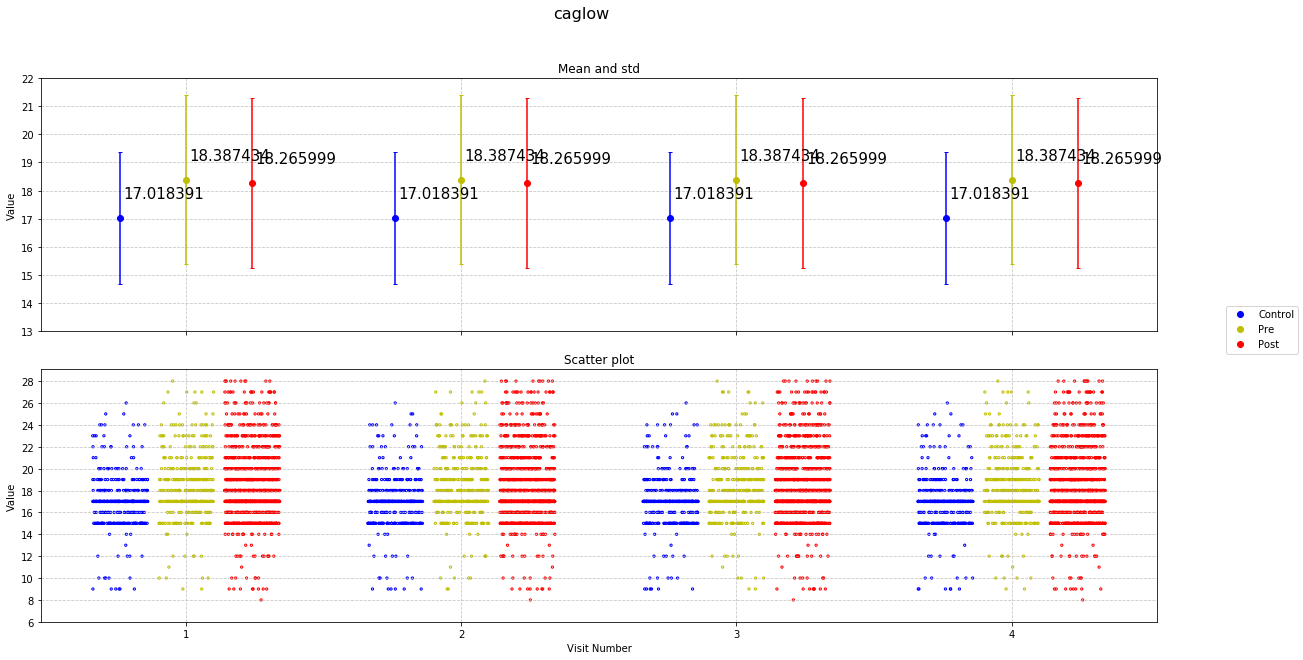

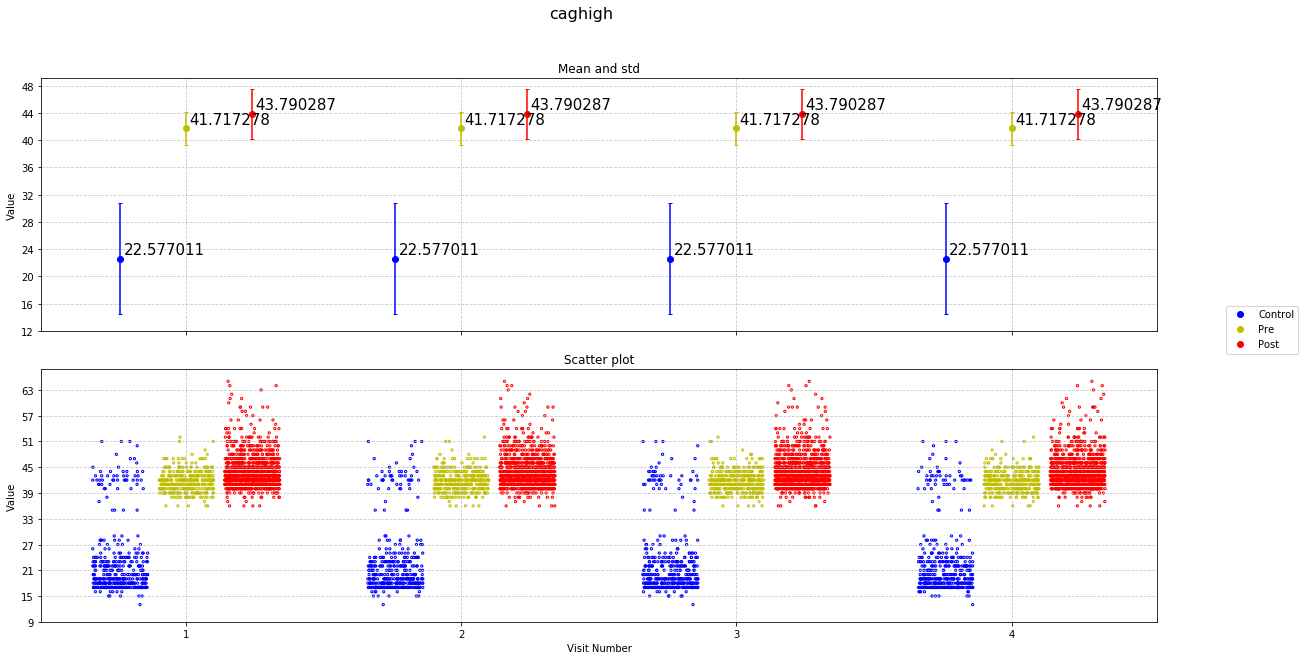

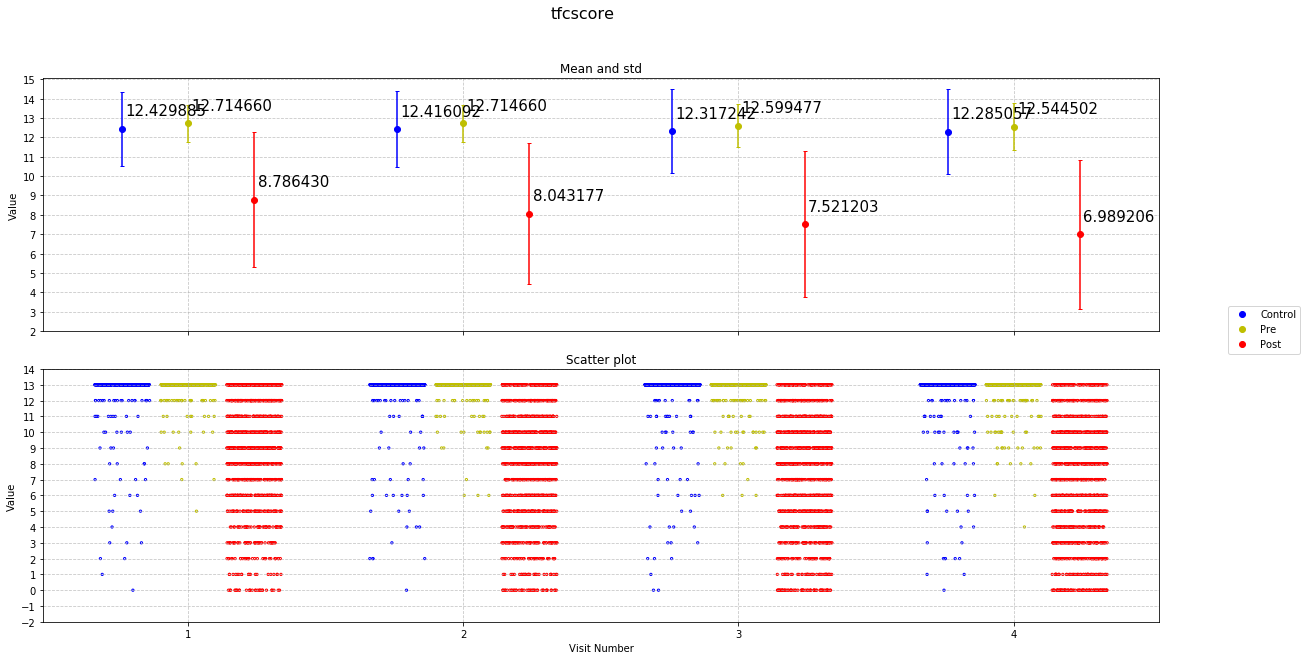

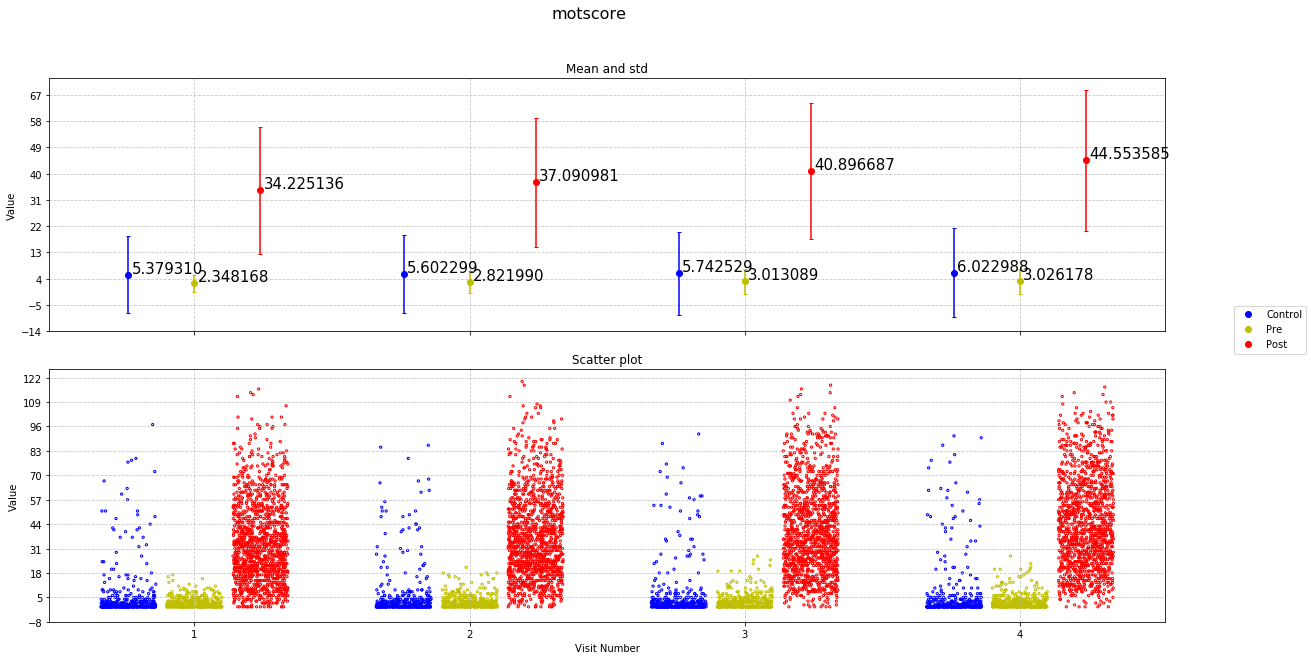

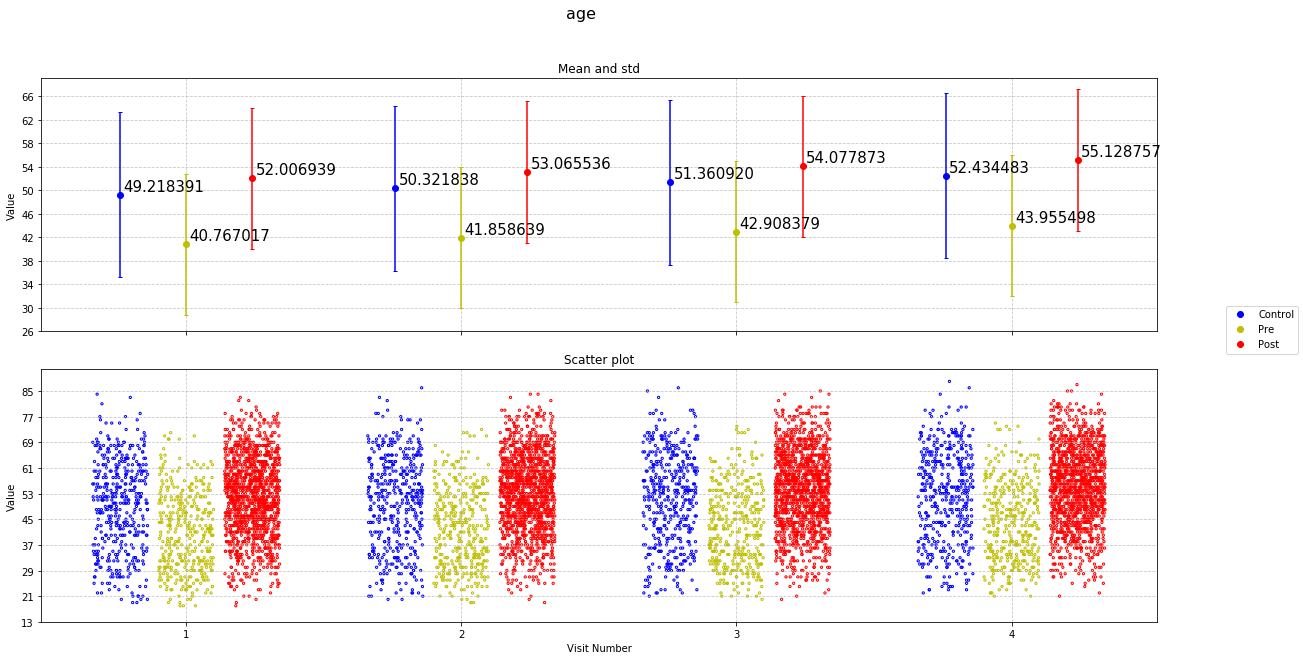

In [8]:
    generate_vars_plots() # caglow and caghigh obviously won't change with time

# Network

## Model definition 

In [9]:

# model #

def create_vae(input_dim, timesteps, batch_size, intermediate_dim, latent_dim, epsilon_std, beta):
    x = Input(shape=(timesteps, input_dim))     # Inputs
    h = LSTM(intermediate_dim)(x)       # LSTM output

    # Latent space
    z_mean = Dense(latent_dim, activation='linear')(h)
    z_log_sigma = Dense(latent_dim, activation='softplus')(h)

    # Sampling

    def sampling(args):
        z_mean, z_log_sigma = args
        epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=epsilon_std)
        return z_mean + K.exp(z_log_sigma) * epsilon

    z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_sigma])

    # decoded LSTM layer

    decoder_h = LSTM(intermediate_dim, return_sequences=True)
    decoder_mean = LSTM(input_dim, return_sequences=True)

    h_decoded = RepeatVector(timesteps)(z)
    h_decoded = decoder_h(h_decoded)

    x_decoded_mean = decoder_mean(h_decoded)

    # end-to-end autoencoder

    vae = Model(x, x_decoded_mean)

    # encoder: inputs to latent space

    encoder = Model(x, z_mean)

    # generator: from latent space to reconstructed inputs

    decoder_input = Input(shape=(latent_dim, ))

    _h_decoded = RepeatVector(timesteps)(decoder_input)
    _h_decoded = decoder_h(_h_decoded)

    _x_decoded_mean = decoder_mean(_h_decoded)

    generator = Model(decoder_input, _x_decoded_mean)

    def vae_loss(x, x_decoded_mean):
        xent_loss = objectives.mse(x, x_decoded_mean)
        kl_loss = - 0.5 * K.mean(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma))
        loss = xent_loss + kl_loss * beta
        return loss

    vae.compile(optimizer='adam', loss=vae_loss)

    return vae, encoder, generator

## Running the model

In [10]:
    # Plots after pred #
    def plot_loss(a,b,c):
        fig = plt.figure(1, figsize=(20,10))
        plt.plot(range(1, len(history.history['loss'])+1), history.history['loss'], label='Training Loss')
        plt.plot(range(1, len(history.history['val_loss'])+1), history.history['val_loss'], label='Validation Loss')
        plt.legend()
        plt.title("batch size %d, latent_dim %d, intermediate_dim %d" % (a,b,c))
        start, end = plt.ylim()
        plt.yticks(np.arange(0, 1.1, 0.05))
        plt.grid(linestyle='--', alpha=0.7)
        plt.show()
        

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 348 samples, validate on 87 samples
Epoch 1/500
 - 2s - loss: 0.9367 - val_loss: 1.2002
Epoch 2/500
 - 0s - loss: 0.8610 - val_loss: 1.0712
Epoch 3/500
 - 0s - loss: 0.7379 - val_loss: 0.8500
Epoch 4/500
 - 0s - loss: 0.6101 - val_loss: 0.7672
Epoch 5/500
 - 0s - loss: 0.5455 - val_loss: 0.7099
Epoch 6/500
 - 0s - loss: 0.4901 - val_loss: 0.6507
Epoch 7/500
 - 0s - loss: 0.4552 - val_loss: 0.6334
Epoch 8/500
 - 0s - loss: 0.4375 - val_loss: 0.6218
Epoch 9/500
 - 0s - loss: 0.4185 - val_loss: 0.5989
Epoch 10/500
 - 0s - loss: 0.4006 - val_loss: 0.5782
Epoch 11/500
 - 0s - loss: 0.3911 - val_loss: 0.5778
Epoch 12/500
 - 0s - loss: 0.3833 - val_loss: 0.5670
Epoch 13/500
 - 0s - loss: 0.3793 - val_loss: 0.5590
Epoch 14/500
 - 0s - loss: 0.3740 - val_loss: 0.5551
Epoch 15/500
 - 0s - loss: 0.3707 - val_loss: 0.5544
Epoch 16/500
 - 0s - loss: 0.3666 - val_loss: 0.5

Epoch 143/500
 - 0s - loss: 0.3336 - val_loss: 0.5272
Epoch 144/500
 - 0s - loss: 0.3336 - val_loss: 0.5309
Epoch 145/500
 - 0s - loss: 0.3336 - val_loss: 0.5256
Epoch 146/500
 - 0s - loss: 0.3331 - val_loss: 0.5277
Epoch 147/500
 - 0s - loss: 0.3330 - val_loss: 0.5313
Epoch 148/500
 - 0s - loss: 0.3327 - val_loss: 0.5269
Epoch 149/500
 - 0s - loss: 0.3328 - val_loss: 0.5275
Epoch 150/500
 - 0s - loss: 0.3327 - val_loss: 0.5276
Epoch 151/500
 - 0s - loss: 0.3328 - val_loss: 0.5298
Epoch 152/500
 - 0s - loss: 0.3326 - val_loss: 0.5288
Epoch 153/500
 - 0s - loss: 0.3325 - val_loss: 0.5291
Epoch 154/500
 - 0s - loss: 0.3325 - val_loss: 0.5276
Epoch 155/500
 - 0s - loss: 0.3324 - val_loss: 0.5269
Epoch 156/500
 - 0s - loss: 0.3327 - val_loss: 0.5304
Epoch 157/500
 - 0s - loss: 0.3327 - val_loss: 0.5282
Epoch 158/500
 - 0s - loss: 0.3324 - val_loss: 0.5272
Epoch 159/500
 - 0s - loss: 0.3324 - val_loss: 0.5271
Epoch 160/500
 - 0s - loss: 0.3323 - val_loss: 0.5273
Epoch 161/500
 - 0s - loss: 

Epoch 295/500
 - 0s - loss: 0.3304 - val_loss: 0.5278
Epoch 296/500
 - 0s - loss: 0.3304 - val_loss: 0.5260
Epoch 297/500
 - 0s - loss: 0.3303 - val_loss: 0.5274
Epoch 298/500
 - 0s - loss: 0.3301 - val_loss: 0.5260
Epoch 299/500
 - 0s - loss: 0.3302 - val_loss: 0.5260
Epoch 300/500
 - 0s - loss: 0.3302 - val_loss: 0.5265
Epoch 301/500
 - 0s - loss: 0.3303 - val_loss: 0.5280
Epoch 302/500
 - 0s - loss: 0.3304 - val_loss: 0.5273
Epoch 303/500
 - 0s - loss: 0.3301 - val_loss: 0.5286
Epoch 304/500
 - 0s - loss: 0.3301 - val_loss: 0.5267
Epoch 305/500
 - 0s - loss: 0.3302 - val_loss: 0.5269
Epoch 306/500
 - 0s - loss: 0.3302 - val_loss: 0.5264
Epoch 307/500
 - 0s - loss: 0.3301 - val_loss: 0.5265
Epoch 308/500
 - 0s - loss: 0.3300 - val_loss: 0.5273
Epoch 309/500
 - 0s - loss: 0.3300 - val_loss: 0.5270
Epoch 310/500
 - 0s - loss: 0.3300 - val_loss: 0.5249
Epoch 311/500
 - 0s - loss: 0.3299 - val_loss: 0.5262
Epoch 312/500
 - 0s - loss: 0.3300 - val_loss: 0.5258
Epoch 313/500
 - 0s - loss: 

Epoch 447/500
 - 0s - loss: 0.3293 - val_loss: 0.5270
Epoch 448/500
 - 0s - loss: 0.3293 - val_loss: 0.5280
Epoch 449/500
 - 0s - loss: 0.3294 - val_loss: 0.5283
Epoch 450/500
 - 0s - loss: 0.3296 - val_loss: 0.5299
Epoch 451/500
 - 0s - loss: 0.3295 - val_loss: 0.5282
Epoch 452/500
 - 0s - loss: 0.3295 - val_loss: 0.5276
Epoch 453/500
 - 0s - loss: 0.3295 - val_loss: 0.5296
Epoch 454/500
 - 0s - loss: 0.3294 - val_loss: 0.5282
Epoch 455/500
 - 0s - loss: 0.3294 - val_loss: 0.5288
Epoch 456/500
 - 0s - loss: 0.3293 - val_loss: 0.5298
Epoch 457/500
 - 0s - loss: 0.3293 - val_loss: 0.5283
Epoch 458/500
 - 0s - loss: 0.3292 - val_loss: 0.5299
Epoch 459/500
 - 0s - loss: 0.3292 - val_loss: 0.5291
Epoch 460/500
 - 0s - loss: 0.3292 - val_loss: 0.5279
Epoch 461/500
 - 0s - loss: 0.3292 - val_loss: 0.5290
Epoch 462/500
 - 0s - loss: 0.3291 - val_loss: 0.5286
Epoch 463/500
 - 0s - loss: 0.3291 - val_loss: 0.5297
Epoch 464/500
 - 0s - loss: 0.3292 - val_loss: 0.5290
Epoch 465/500
 - 0s - loss: 

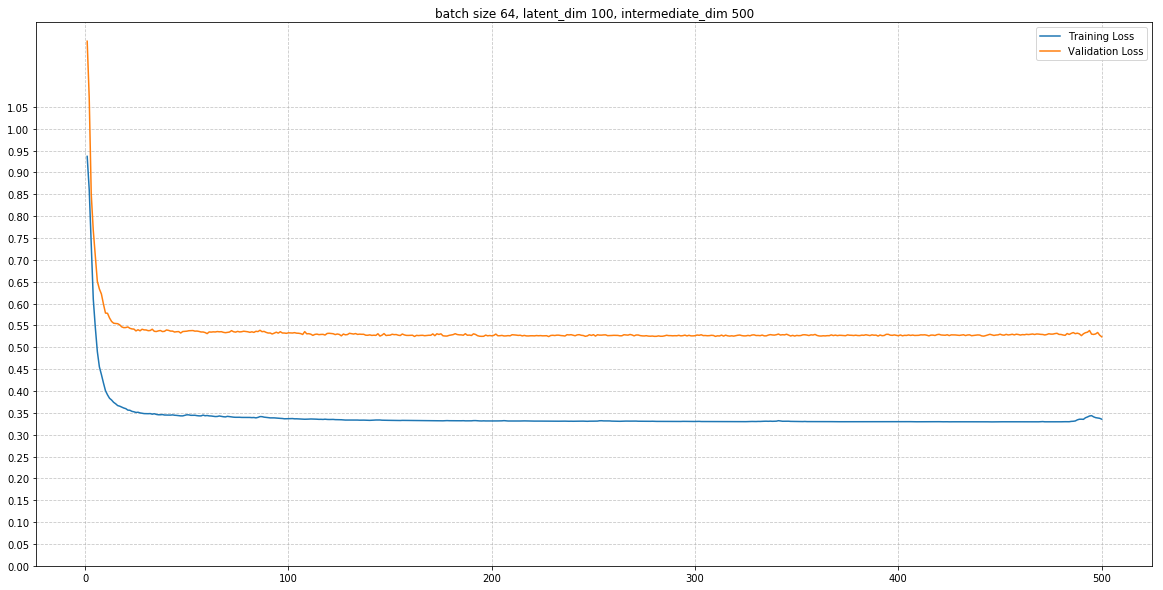

In [11]:
    # Normalization:

    control_data -= mean
    std = control_data.std(axis=0)
    control_data /= std
    pre_data -= mean
    pre_data /= std
    post_data -= mean
    post_data /= std


    # Run the model #

    input_dim = len(_vars)  # vars
    timesteps = NR_VISITS  # visits
    batch_size =   64 # 
    epsilon_std = 1.  #
    latent_dim = 100  #
    epochs = 500  #
    intermediate_dim = 500  #
    beta = 0 # Param for KL loss
    
    vae, enc, gen = create_vae(input_dim, timesteps, batch_size, intermediate_dim, latent_dim, epsilon_std, beta)
    np.random.shuffle(control_data)
    history = vae.fit(control_data, control_data, epochs=epochs, validation_split=0.20, batch_size=batch_size, verbose=2)
    preds = vae.predict(control_data, batch_size=batch_size)
    plot_loss(batch_size, latent_dim, intermediate_dim)
    
    #for batch_size in [4,8,16,32,64,128,256]:
    #    for latent_dim in [1,5,10,25,50,100,256, 512]:
    #        for intermediate_dim in [10,25,64,128,256,512]:
    #            vae, enc, gen = create_vae(input_dim, timesteps, batch_size, intermediate_dim, latent_dim, epsilon_std, beta)
    #            np.random.shuffle(control_data)
    #            history = vae.fit(control_data, control_data, epochs=epochs, validation_split=0.2, batch_size=batch_size, verbose=0)
    #            preds = vae.predict(control_data, batch_size=batch_size)
    #            print("[plotting...]")
    #            print("x: %s, preds: %s" % (control_data.shape, preds.shape))
    #            plot_loss(batch_size, latent_dim, intermediate_dim)
    
    #batch_size = 32
    
    #for latent_dim in [1,5,10,25,50,100,200]:
     #   vae, enc, gen = create_vae(input_dim, timesteps, batch_size, intermediate_dim, latent_dim, epsilon_std, beta)
       # np.random.shuffle(control_data)
        #history = vae.fit(control_data, control_data, epochs=epochs, validation_split=0.2, batch_size=batch_size, verbose=0)
        #preds = vae.predict(control_data, batch_size=batch_size)
        #print("[plotting...]")
        #print("x: %s, preds: %s" % (control_data.shape, preds.shape))
        #plot_loss(latent_dim)
        
    #latent_dim = 50
    
    #for intermediate_dim in [10,25,64,128,200]:
      #  vae, enc, gen = create_vae(input_dim, timesteps, batch_size, intermediate_dim, latent_dim, epsilon_std, beta)
       # np.random.shuffle(control_data)
       # history = vae.fit(control_data, control_data, epochs=epochs, validation_split=0.2, batch_size=batch_size, verbose=0)
        #preds = vae.predict(control_data, batch_size=batch_size)
        #print("[plotting...]")
        #print("x: %s, preds: %s" % (control_data.shape, preds.shape))
        #plot_loss(intermediate_dim)
    

# Prediction plots

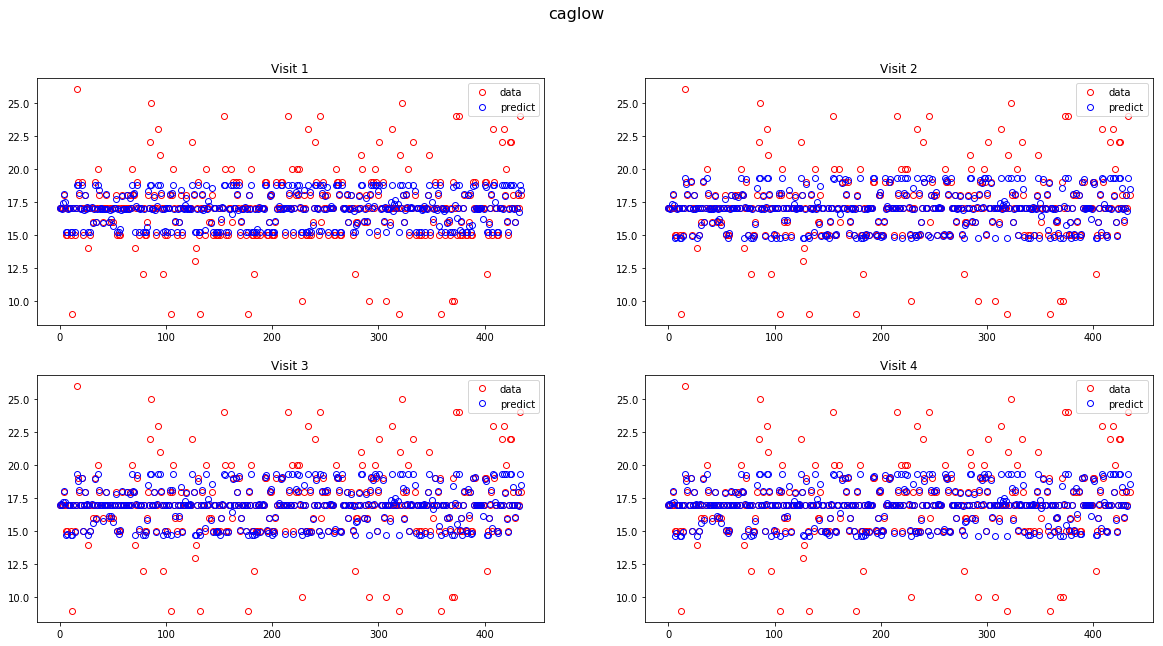

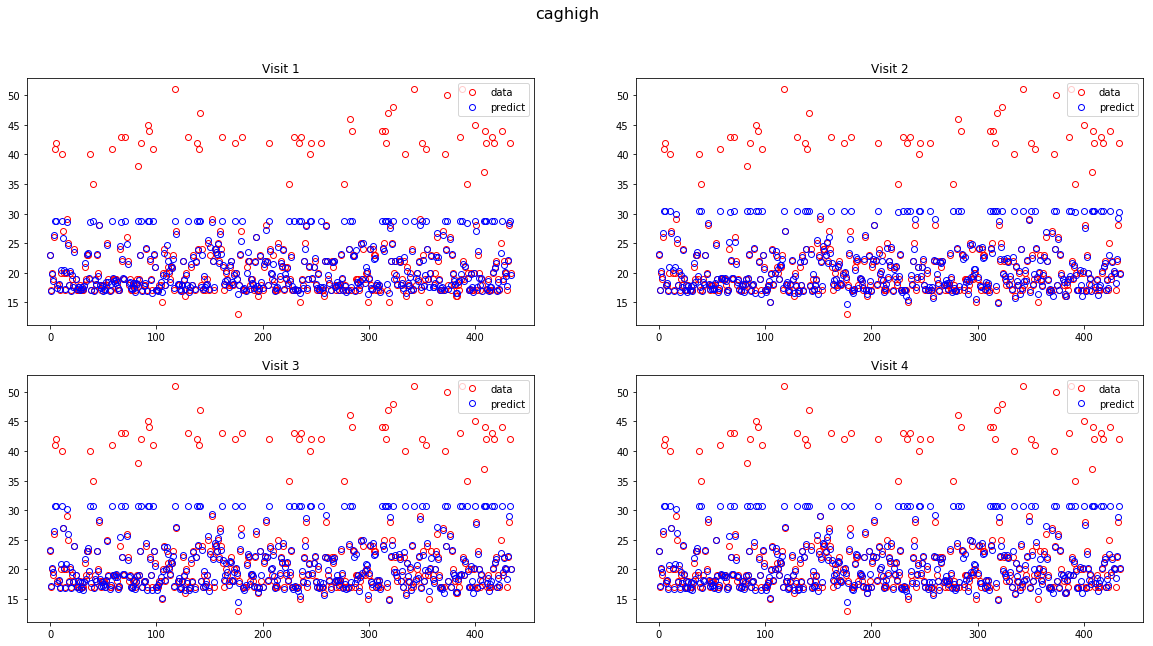

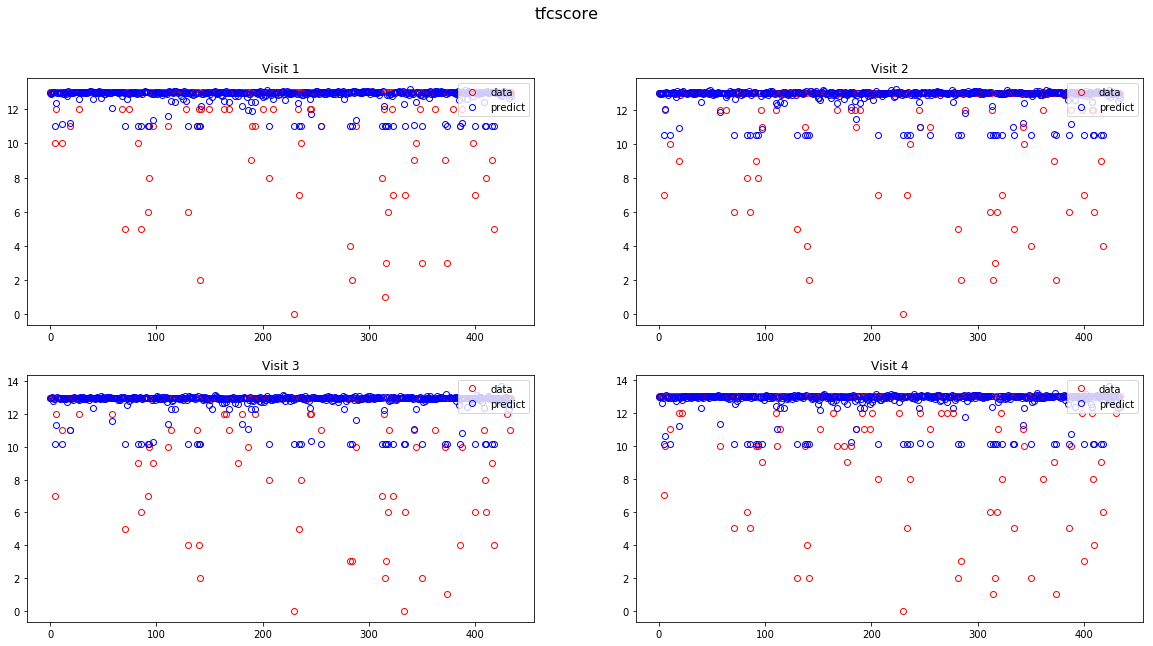

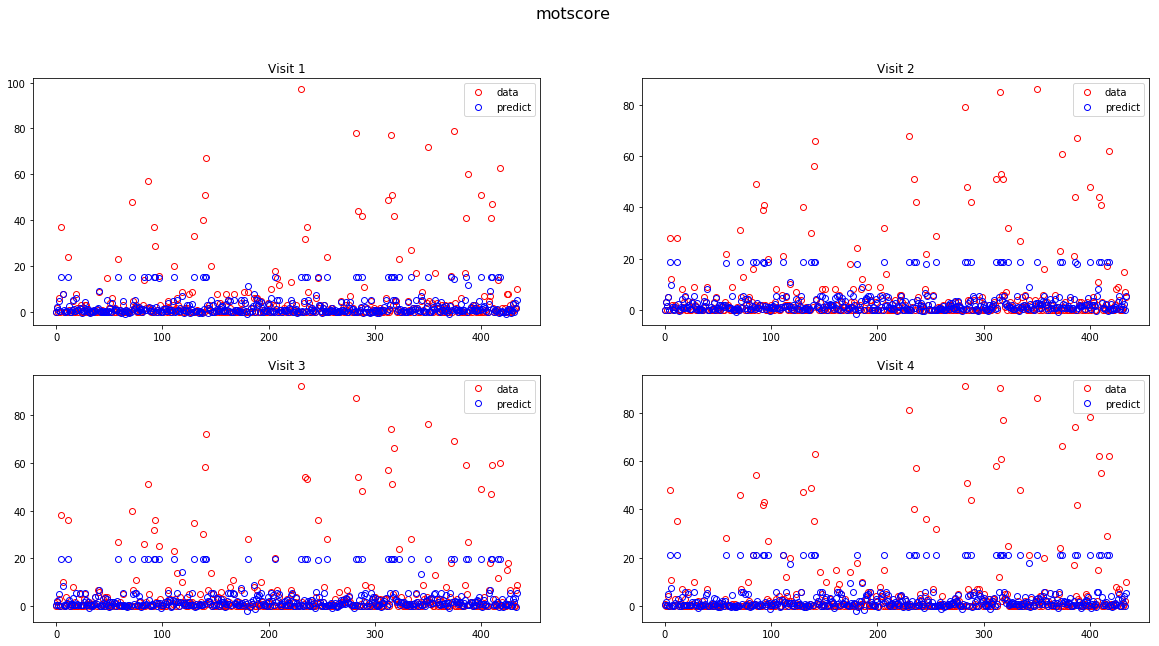

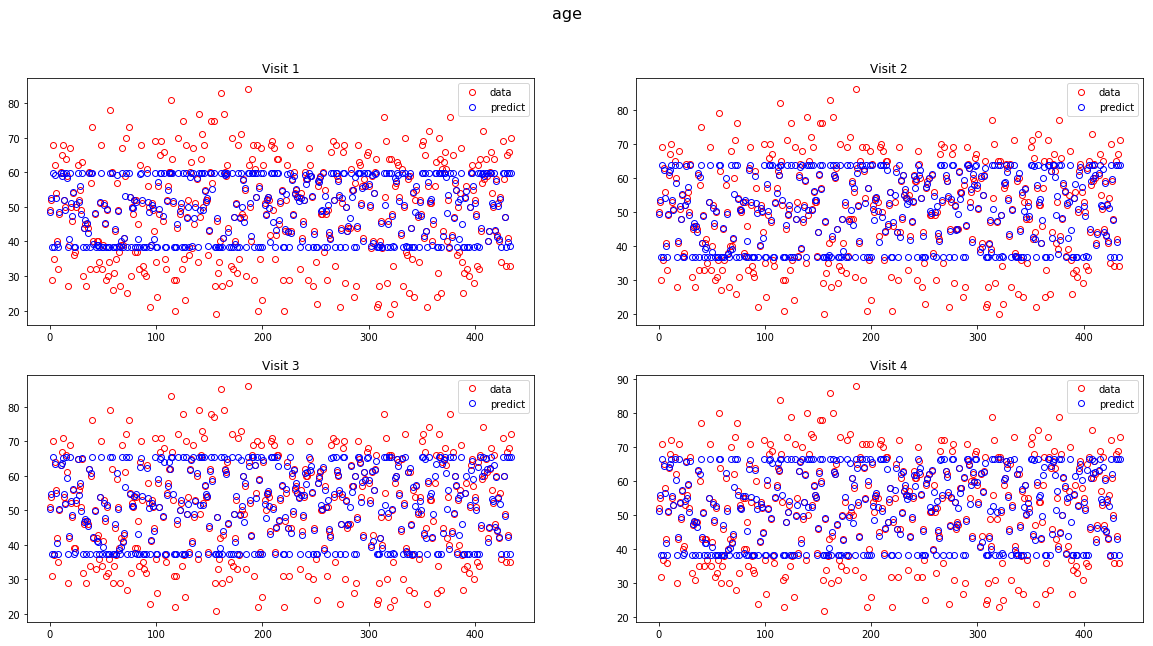

In [12]:
        # Denormalization
        
        control_data *= std
        control_data += mean
        preds *= std
        preds += mean
        
        generate_pred_plots()